In [1]:
import torch
from torch import optim
from torch.nn.functional import cross_entropy

In [2]:
import matplotlib.pyplot as plt

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
from src.custom_audio_dataset import CustomAudioDataset
from src.models import CnnMFCC
from src.utils import pad_collate_fn, plot_spectrogram
from src.datasets import get_data_path
from src.custom_layers import PadOrTruncateLayer

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

MAX_EPOCH = 20

SAMPLE_RATE = 16_000
MAX_SECONDS_DURATION = 8

MAX_FEATURES_IN = SAMPLE_RATE * MAX_SECONDS_DURATION

In [6]:
annotations_file_path, data_dir_path = get_data_path("hesitation_dev")

data_transform = torch.nn.Sequential(
    PadOrTruncateLayer(MAX_FEATURES_IN)
)

dev_dataset = CustomAudioDataset(annotations_file_path, data_dir_path, data_transform=data_transform)

# Usage in DataLoader
train_dataloader = torch.utils.data.DataLoader(
    dataset=dev_dataset,
    batch_size=32,
    # collate_fn=pad_collate_fn
)

In [7]:
model = CnnMFCC(n_classes=2, sample_rate=SAMPLE_RATE, max_audio_length_seconds=MAX_SECONDS_DURATION)
model = model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=0.0003)

/home/glucas11/projects/repos/speech_feedback/.venv/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [11]:
model

CnnMFCC(
  (feature_extractor): Sequential(
    (0): MFCC(
      (amplitude_to_DB): AmplitudeToDB()
      (MelSpectrogram): MelSpectrogram(
        (spectrogram): Spectrogram()
        (mel_scale): MelScale()
      )
    )
  )
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2))
    (1): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
    (2): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=35392, out_features=2, bias=True)
  )
  (net): Sequential(
    (0): Sequential(
      (0): MFCC(
        (amplitude_to_DB): AmplitudeToDB()
        (MelSpectrogram): MelSpectrogram(
          (spectrogram): Spectrogram()
          (mel_scale): MelScale()
        )
      )
    )
    (1): Sequential(
      (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2))
      (1): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
      (2): Flatten(start_dim=1, end_dim=-1)
    )
    (2): Sequential(
      (0): Linear(in_features=35392, out

In [8]:
for i in range(MAX_EPOCH):
	losses = []
	for batch_idx, (data, target) in enumerate(train_dataloader):
		optimizer.zero_grad()
		data, target = data.to(DEVICE), target.to(DEVICE)
		logits = model(data)
		loss = cross_entropy(logits, target)
		losses.append(loss.item())
		loss.backward()
		optimizer.step()
	print(sum(losses)/len(losses))

1.6472682559485434
0.5036323955452795
0.7758635323686647
0.3902799652610377
0.2585653820090686
0.18974745175508834
0.2069985503423217
0.23609537642034725
0.1543028726926608
0.1355513537287558
0.15858237062690758
0.10118218127039015
0.05480133744366775
0.04190611172151669
0.019142034052867265
0.019169490162578448
0.012491332981219886
0.00566958589365696
0.005503847354904334
0.01308072789749846


In [9]:
preds = []
targets = []
with torch.no_grad():
	for batch_idx, (data, target) in enumerate(train_dataloader):
		optimizer.zero_grad()
		data, target = data.to(DEVICE), target.to(DEVICE)
		logits = model(data)
		preds.append(torch.max(logits, dim=1).indices)
		targets.append(target)

preds = torch.concat(preds)
targets = torch.concat(targets)

sum(preds == targets)/len(preds)

tensor(0.9634, device='cuda:0')

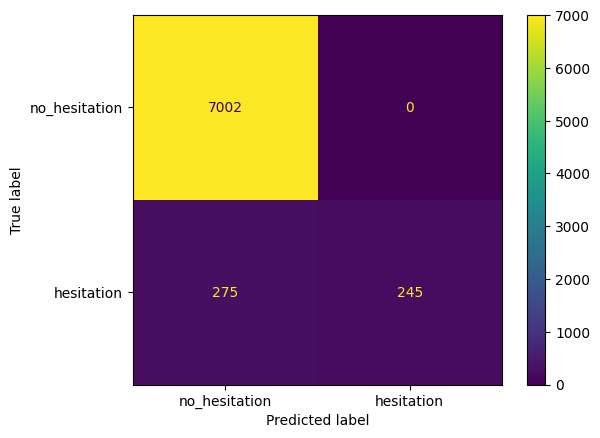

In [10]:
cm =confusion_matrix(targets.cpu().numpy(), preds.cpu().numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no_hesitation', 'hesitation'])

disp.plot()
plt.show()